In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import colors
import matplotlib.gridspec as gridspec
import pandas as pd
from tqdm import tqdm
import pickle
import scipy
plt.style.use('luca')
mpl.font_manager._rebuild()
%matplotlib inline 

### Plot for Proposal December 2018

This plot shows a comparison between MC model and the SE rate after a primary S2 in Background and Radon calibration data. SE Rate histograms are loaded from data. Additionally 1D histograms of the S2 size in given data types are loaded and used by the ToyMC model to saple the S2 size and event rate from. 

In [2]:
#Load SE Rate histograms:
with open('sr1_se_rate.pkl', 'rb') as handle:
    data_hists_dict = pickle.load(handle)
    
#Load S2 size histograms:
with open('s2_spectrum_per_source_sr1.pkl', 'rb') as handle:
    sampling_dict = pickle.load(handle)

In [3]:
#Toy MC definitions
def rate_function(scaling_constant, time_scale, dt_bins):
    y = scaling_constant*np.exp(-dt_bins/time_scale)
    return (y)


def se_histogram(event_rate, # Number of events assumed to occur within 1s
                 background_rate, # Flat background rate of Single Electrons 
                 time_scale, # Time Scale of exponential decay of trapped electrons
                 scaling_constant, #Fraction of electrons relative to S2 size 
                 source = 'Background', # Primary S2 spectrum for sampling from
                 time_bins=100, # Number of bins in time
                 window_length=1000 #Length after given S2 to look at
                ):
    
    #Determine number of events in timw window
    number_of_events = np.random.poisson(event_rate) #Event rate in window....
    
    #Assign random times to S2s in window following S2, leaving first S2 at t=0 
    if number_of_events>1:
        time_of_s2s=np.random.random(number_of_events-1)
        time_of_s2s=np.concatenate(([0], time_of_s2s))
    else:
        number_of_events = 1
        time_of_s2s=np.array([0])
    
    bin_width=window_length/time_bins
    
    #Sample from Appropriate S2 Size Spectrum (produced previously)
    s2_spectrum_hist = sampling_dict[source]['hist']    
    s2_size = np.random.choice(s2_spectrum_hist.bin_centers, 
                               number_of_events, 
                               p =(s2_spectrum_hist[:])/np.sum(s2_spectrum_hist[:]))
    s2_size=10**s2_size
    
    #Initialize Arrays of SE rate
    se_rate=[background_rate]*time_bins
    dt_bins=np.linspace(0, window_length, time_bins+1)
    
    #print(s2_size)
    
    for is2, s2 in enumerate(time_of_s2s):
        s2 = s2 * window_length # Span window length, assumed to be in ms
        bin_offset = np.digitize(s2, dt_bins) 
        counts = rate_function(scaling_constant = scaling_constant*s2_size[is2], 
                               time_scale=time_scale, 
                               dt_bins=dt_bins)
        event_len =  time_bins-bin_offset
        zero_array = np.array([0]*int(bin_offset))
        counts = np.concatenate((np.array(zero_array), counts[:event_len]))
        se_rate += counts
    
    dt_bin_centers = dt_bins[1:]-(dt_bins[1:]-dt_bins[:-1])/2
    
    return dt_bin_centers, se_rate   

In [4]:
#Define function to add subplot axes
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3] 
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

#Definition of cut base on a single exponential model
def cut_definition(tau, c, s2, electrons):
    time = tau * np.log(c*tau*s2/electrons)
    return time

In [5]:
#Make ToyMC Rates
waveforms = 10000
time_bins = 200
window_length=100
x_bins = [0]*time_bins
y_bins = [0]*time_bins
s2_bins=np.logspace(2, 7, 101)

### Plot Bkg Data and Fit ###
source='Background' 
source_rate = sampling_dict[source]['event_rate']
event_rate = source_rate*window_length/1000 #Event rate in s, window length in ms

#Produce best Fit model
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.17, 
                                               time_scale = 4.31,
                                               scaling_constant = 2.15e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
best_fit_bkg=y_bins/waveforms

#Plus 1-sigma Model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.17+0.1, 
                                               time_scale = 4.31+0.25,
                                               scaling_constant = 2.15e-05+0.2e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
p1sigma_bkg=y_bins/waveforms

#Minus 1-sigma Model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.17-0.1, 
                                               time_scale = 4.31-0.25,
                                               scaling_constant = 2.15e-05-0.2e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
m1sigma_bkg=y_bins/waveforms

### Plot Radon Data and Fit ###
waveforms=100000
source='Radon' 
source_rate = sampling_dict[source]['event_rate']
event_rate = source_rate*window_length/1000 #Event rate in s, window length in ms

#Produce best Fit model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.68, 
                                               time_scale = 7.9,
                                               scaling_constant = 2.73e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
best_fit_rn=y_bins/waveforms

#Plus 1-sigma Model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.68+0.1, 
                                               time_scale = 7.9+0.25,
                                               scaling_constant = 2.73e-05+0.2e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
p1sigma_rn=y_bins/waveforms

#Minus 1-sigma Model
y_bins = [0]*time_bins
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=2.68-0.1, 
                                               time_scale = 7.9-0.25,
                                               scaling_constant = 2.73e-05-0.2e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
m1sigma_rn=y_bins/waveforms

x_bins = dt_bin_centers 

100%|██████████| 100000/100000 [00:22<00:00, 4467.06it/s]


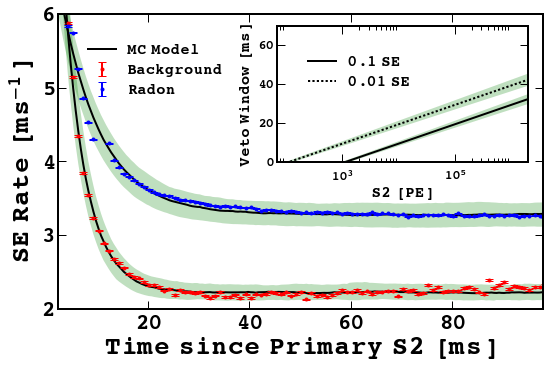

In [26]:
#Produce Plot
fig, ax = plt.subplots(figsize=(8.7, 5.4))
plot_start=8
plot_end=198
tau=4.31
c=2.15e-5

# Plot MC Models and Data
source='Background'
ax.fill_between(x_bins, m1sigma_bkg, p1sigma_bkg, facecolor='green', interpolate=True, alpha = 0.25)
ax.plot(x_bins, best_fit_bkg, label='MC Model', linestyle='-', color='black')
x=x_bins[plot_start:plot_end:2]
y=data_hists_dict[source]['rate'][plot_start:plot_end:2]
yerr_lower=data_hists_dict[source]['lower'][plot_start:plot_end:2]
yerr_upper=data_hists_dict[source]['upper'][plot_start:plot_end:2]
ax.errorbar(x=x, 
             y=y,
             yerr=[y-yerr_lower, yerr_upper-y],
             label='Background', fmt='.',
             color='red')

source='Radon'
ax.fill_between(x_bins, m1sigma_rn, p1sigma_rn, facecolor='green', interpolate=True, alpha = 0.25)
ax.plot(x_bins, best_fit_rn, linestyle='-', color='black')
x=x_bins[plot_start:plot_end:2]
y=data_hists_dict[source]['rate'][plot_start:plot_end:2]
yerr_lower=data_hists_dict[source]['lower'][plot_start:plot_end:2]
yerr_upper=data_hists_dict[source]['upper'][plot_start:plot_end:2]
#Remove data points around HEVeto
x=np.append(x[0:6], x[8:])
y=np.append(y[0:6], y[8:])
yerr_lower=np.append(yerr_lower[0:6], yerr_lower[8:])
yerr_upper=np.append(yerr_upper[0:6], yerr_upper[8:])
ax.errorbar(x=x, 
             y=y,
             yerr=[y-yerr_lower, yerr_upper-y],
             label='Radon', fmt='.',
             color='Blue')

plt.legend(loc = (0.05, 0.7), fontsize=14)
plt.ylim([2,6])
plt.xlim([x_bins[4], 98])
plt.ylabel('SE Rate [ms$^{-1}$]')
plt.xlabel('Time since Primary S2 [ms]')


### Create Subplot for Veto Cut ###
inset = fig.add_axes([0.475,0.5,0.40,0.35])
plt.sca(inset)

#subpos = [0.5,0.6,0.5,0.5] #Position and Dimensions
#subax1=fig.add_subplot(111)
#subax1=add_subplot_axes(ax, subpos)

#Cut 1
electrons=0.1
plt.plot(s2_bins, cut_definition(tau, c, s2_bins, electrons), linestyle='-', color='black', label= '0.1 SE')
plt.fill_between(s2_bins, 
                    cut_definition(tau-0.25, c-0.2e-05, s2_bins, electrons), 
                    cut_definition(tau+0.25, c+0.2e-05, s2_bins, electrons), 
                    facecolor='green', interpolate=True, alpha = 0.25)

#Cut 2
electrons=0.01
plt.plot(s2_bins, cut_definition(tau, c, s2_bins, electrons), linestyle=':', color='black', label= '0.01 SE')
plt.fill_between(s2_bins, 
                    cut_definition(tau-0.25, c-0.2e-05, s2_bins, electrons), 
                    cut_definition(tau+0.25, c+0.2e-05, s2_bins, electrons), 
                    facecolor='green', interpolate=True, alpha = 0.25)

#Format SubPlot
plt.legend(loc=(0.1, 0.5), fontsize=14)
plt.xscale('log')
plt.xlim([70, 2e6])
plt.ylim([0, 70])
plt.yticks(np.arange(0, 70, 20), fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Veto Window [ms]', fontsize = 14)
plt.xlabel('S2 [PE]', fontsize = 14)
fig.savefig("fig_mc_data_match.png")
fig.savefig("fig_mc_data_match.pdf")

plt.show()